In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

 1.1.png
 1.2.png
 1.3.docx
 1.3.gdoc
 1.4.docx
'17. SoDI_Odd Semester End Examination_Dec 2024_14.11.2024.gdoc'
'17. SoDI_Odd Semester End Examination_Dec 2024_14.11.2024.pdf'
 1.htm
 1mean_example.gsheet
'1. Odd Semester_Theory Examination Schedule_December 2024_14.11.2024 (1).gdoc'
'1. Odd Semester_Theory Examination Schedule_December 2024_14.11.2024.gdoc'
'1. Odd Semester_Theory Examination Schedule_December 2024_14.11.2024.pdf'
'1RVU23CSE169_CLOUD LABS - 1,2 & 3.gdoc'
 1RVU23CSE169_Confirmation_Page_for_NPTEL_Course_Enrollment.pdf
 1RVU23CSE169_daa_practicals_5a_2.c.gdoc
'1RVU23CSE169_GOKUL ARVIND VR_HOME ASSIGNMENT1.gdoc'
'1RVU23CSE169_GOKUL ARVIND VR_HOME ASSIGNMENT2.gdoc'
 1RVU23CSE169_GOKUL_ARVIND_VR.logic
 1RVU23CSE169_Gokul_Arvind_VR.png
 1RVU23CSE169_GOKUL_HOMEASSIGNMENT1.gdoc
 1RVU23CSE169_GOKUL_HOMEASSIGNMENT2.gdoc
 1RVU23CSE169_Gokul_Program25.2.gdoc
 1RVU23CSE169_Gokul_Program25.3.gdoc
 1RVU23CSE169_Gokul_Program26.gdoc
 1RVU23CSE169_Gokul_Program27.gdoc
 1RVU23CSE169_G

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/Flickr2K'
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extracted to:", extract_path)

Extracted to: /content/Flickr2K


In [ ]:
ls /content/Flickr2K/Flickr2K/

Flickr2K_HR/  Flickr2K_LR_bicubic/  Flickr2K_LR_unknown/


In [ ]:
# 1. Import Libraries
import os
import math
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# 2. Dataset Loader (DIV2K)
class Flickr2KDataset(Dataset):
    def __init__(self, hr_size=128, scale=4, train=True):
        self.hr_path = "/content/Flickr2K//Flickr2K/Flickr2K_HR" if train else "/content/Flickr2K/Flickr2K/Flickr2K_LR_bicubic"
        self.hr_size = hr_size
        self.scale = scale
        self.image_files = sorted([f for f in os.listdir(self.hr_path) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.hr_path, self.image_files[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        top = np.random.randint(0, h - self.hr_size)
        left = np.random.randint(0, w - self.hr_size)
        hr_img = img[top:top+self.hr_size, left:left+self.hr_size]
        lr_img = cv2.resize(hr_img, (self.hr_size // self.scale, self.hr_size // self.scale), interpolation=cv2.INTER_CUBIC)

        hr_img = torch.tensor(hr_img / 127.5 - 1).permute(2, 0, 1).float()
        lr_img = torch.tensor(lr_img / 127.5 - 1).permute(2, 0, 1).float()
        return {'lr': lr_img, 'hr': hr_img}

# 3. SwinIR-like Model (Simplified)
class SwinIR(nn.Module):
    def __init__(self, in_chans=3, embed_dim=64, depths=4, upscale=4):
        super(SwinIR, self).__init__()

        self.mean = torch.Tensor([0.4488, 0.4371, 0.4040]).view(1, 3, 1, 1)
        self.upscale = upscale

        self.conv_first = nn.Conv2d(in_chans, embed_dim, 3, 1, 1)

        # Deep feature extractor
        layers = []
        for _ in range(depths):
            layers.append(nn.Sequential(
                nn.Conv2d(embed_dim, embed_dim, 3, 1, 1),
                nn.BatchNorm2d(embed_dim),
                nn.ReLU(inplace=True)
            ))
        self.layers = nn.Sequential(*layers)

        self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)

        # Upsampling
        self.upsample = self.build_upsample(upscale, embed_dim)
        self.conv_last = nn.Conv2d(embed_dim, in_chans, 3, 1, 1)

    def build_upsample(self, scale, num_feat):
        layers = []
        if (scale & (scale - 1)) == 0:
            for _ in range(int(math.log(scale, 2))):
                layers.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                layers.append(nn.PixelShuffle(2))
                layers.append(nn.ReLU(inplace=True))
        elif scale == 3:
            layers.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            layers.append(nn.PixelShuffle(3))
            layers.append(nn.ReLU(inplace=True))
        else:
            raise ValueError(f"Unsupported upscale: {scale}")
        return nn.Sequential(*layers)

    def forward(self, x):
        self.mean = self.mean.to(x.device)
        x = x - self.mean

        x = self.conv_first(x)
        x = self.layers(x)
        x = self.conv_after_body(x)
        x = self.upsample(x)
        x = self.conv_last(x)

        x = x + self.mean
        return x

# 4. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = Flickr2KDataset(train=True)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = SwinIR().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
save_path = "/content/swinir_div2k.pth"

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)

        sr = model(lr)
        loss = criterion(sr, hr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(dataloader):.4f}")

# 5. Save Model
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

# 6. Load Model
model.load_state_dict(torch.load(save_path))
model.eval()

# 7. Evaluation Metrics
def evaluate_metrics(model, dataset, num_samples=5):
    psnr_vals, ssim_vals = [], []
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            lr = sample['lr'].unsqueeze(0).to(device)
            hr = sample['hr'].permute(1, 2, 0).numpy()
            sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()

            hr = ((hr + 1) * 127.5).astype(np.uint8)
            sr = ((sr + 1) * 127.5).astype(np.uint8)

            psnr_vals.append(psnr_metric(hr, sr, data_range=255))
            ssim_vals.append(ssim_metric(hr, sr, channel_axis=-1))

    print(f"PSNR: {np.mean(psnr_vals):.2f} dB")
    print(f"SSIM: {np.mean(ssim_vals):.4f}")

# 8. Visualize Result
def show_sr_result(model, dataset, idx=0):
    with torch.no_grad():
        sample = dataset[idx]
        lr = sample['lr'].unsqueeze(0).to(device)
        sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()
        hr = sample['hr'].permute(1, 2, 0).numpy()
        lr = sample['lr'].permute(1, 2, 0).numpy()

        sr = (sr + 1) * 127.5
        hr = (hr + 1) * 127.5
        lr = (lr + 1) * 127.5

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(lr.astype(np.uint8))
        plt.title("Low-Res Input")
        plt.subplot(1, 3, 2)
        plt.imshow(sr.astype(np.uint8))
        plt.title("Super-Resolved Output")
        plt.subplot(1, 3, 3)
        plt.imshow(hr.astype(np.uint8))
        plt.title("High-Res Ground Truth")
        plt.show()

# Run evaluation
val_dataset = Flickr2KDataset(train=False)
evaluate_metrics(model, val_dataset, num_samples=10)
show_sr_result(model, val_dataset, idx=0)

Epoch 1/5: 100%|██████████| 332/332 [04:52<00:00,  1.14it/s]


Epoch 1: Avg Loss = 0.2506


Epoch 2/5: 100%|██████████| 332/332 [04:40<00:00,  1.18it/s]


Epoch 2: Avg Loss = 0.1856


Epoch 3/5: 100%|██████████| 332/332 [04:38<00:00,  1.19it/s]


Epoch 3: Avg Loss = 0.1605


Epoch 4/5: 100%|██████████| 332/332 [04:40<00:00,  1.18it/s]


Epoch 4: Avg Loss = 0.1459


Epoch 5/5: 100%|██████████| 332/332 [04:41<00:00,  1.18it/s]


Epoch 5: Avg Loss = 0.1365
Model saved to: /content/swinir_div2k.pth


IndexError: list index out of range

In [ ]:
class Flickr2KDataset(Dataset):
    def __init__(self, hr_size=128, scale=4, train=True):
        self.train = train
        self.hr_size = hr_size
        self.scale = scale
        if self.train:
            self.hr_path = "/content/Flickr2K/Flickr2K/Flickr2K_HR"
            self.lr_path = "/content/Flickr2K/Flickr2K/Flickr2K_LR"  # Correct path for LR images
        else:
            self.lr_path = "/content/Flickr2K/Flickr2K/Flickr2K_LR"  # Correct path for LR images
            self.hr_path = "/content/Flickr2K/Flickr2K/Flickr2K_HR"

        self.image_files = sorted([
            f for f in os.listdir(self.hr_path if train else self.lr_path)
            if f.endswith('.png')
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if self.train:
            img = cv2.imread(os.path.join(self.hr_path, self.image_files[idx]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img.shape[:2]
            top = np.random.randint(0, h - self.hr_size)
            left = np.random.randint(0, w - self.hr_size)
            hr_img = img[top:top+self.hr_size, left:left+self.hr_size]
            lr_img = cv2.resize(hr_img, (self.hr_size // self.scale, self.hr_size // self.scale), interpolation=cv2.INTER_CUBIC)
        else:
            hr_img_path = os.path.join(self.hr_path, self.image_files[idx])
            lr_img_path = os.path.join(self.lr_path, self.image_files[idx])

            print(f"HR image path: {hr_img_path}")
            print(f"LR image path: {lr_img_path}")

            lr_img = cv2.imread(lr_img_path)
            hr_img = cv2.imread(hr_img_path)

            # Check if the images are loaded correctly
            if lr_img is None:
                raise FileNotFoundError(f"Failed to load LR image: {lr_img_path}")
            if hr_img is None:
                raise FileNotFoundError(f"Failed to load HR image: {hr_img_path}")

            lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
            hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)

        hr_img = torch.tensor(hr_img / 127.5 - 1).permute(2, 0, 1).float()
        lr_img = torch.tensor(lr_img / 127.5 - 1).permute(2, 0, 1).float()
        return {'lr': lr_img, 'hr': hr_img}


In [ ]:
def evaluate_metrics(model, dataset, num_samples=5):
    print("Starting evaluation...")
    psnr_vals, ssim_vals = [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            lr = sample['lr'].unsqueeze(0).to(device)
            hr = sample['hr'].permute(1, 2, 0).numpy()

            print(f"Processing sample {i+1}")
            print(f"LR shape: {lr.shape}, HR shape: {hr.shape}")  # Check if shapes are as expected

            sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()

            # Rescale images to original pixel values
            hr = ((hr + 1) * 127.5).astype(np.uint8)
            sr = ((sr + 1) * 127.5).astype(np.uint8)

            # Calculate PSNR and SSIM
            psnr_vals.append(psnr_metric(hr, sr, data_range=255))
            ssim_vals.append(ssim_metric(hr, sr, channel_axis=-1))

    # Check if metrics are computed and print them
    if psnr_vals and ssim_vals:
        print(f"Average PSNR: {np.mean(psnr_vals):.2f} dB")
        print(f"Average SSIM: {np.mean(ssim_vals):.4f}")
    else:
        print("No valid metrics were calculated.")


In [ ]:
import os
import math
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# 1. Dataset Loader (Flickr2K)
class Flickr2KDataset(Dataset):
    def __init__(self, hr_size=128, scale=4, train=True):
        self.hr_path = "/content/Flickr2K/Flickr2K/Flickr2K_HR"
        self.lr_path = "/content/Flickr2K/Flickr2K/Flickr2K_LR_bicubic/X4"

        self.hr_size = hr_size
        self.scale = scale
        self.image_files = sorted([f for f in os.listdir(self.hr_path) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.hr_path, self.image_files[idx])
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Could not load image: {img_path}")

        h, w = img.shape[:2]
        if h < self.hr_size or w < self.hr_size:
            return self.__getitem__((idx + 1) % len(self))

        top = np.random.randint(0, h - self.hr_size)
        left = np.random.randint(0, w - self.hr_size)
        hr_img = img[top:top+self.hr_size, left:left+self.hr_size]
        lr_img = cv2.resize(hr_img, (self.hr_size // self.scale, self.hr_size // self.scale), interpolation=cv2.INTER_CUBIC)

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)

        hr_img = torch.tensor(hr_img / 127.5 - 1).permute(2, 0, 1).float()
        lr_img = torch.tensor(lr_img / 127.5 - 1).permute(2, 0, 1).float()

        return {'lr': lr_img, 'hr': hr_img}

# 2. SwinIR-like Model (Simplified)
class SwinIR(nn.Module):
    def __init__(self, in_chans=3, embed_dim=64, depths=4, upscale=4):
        super(SwinIR, self).__init__()
        self.register_buffer('mean', torch.Tensor([0.4488, 0.4371, 0.4040]).view(1, 3, 1, 1))
        self.upscale = upscale

        self.conv_first = nn.Conv2d(in_chans, embed_dim, 3, 1, 1)

        layers = []
        for _ in range(depths):
            layers.append(nn.Sequential(
                nn.Conv2d(embed_dim, embed_dim, 3, 1, 1),
                nn.BatchNorm2d(embed_dim),
                nn.ReLU(inplace=True)
            ))
        self.layers = nn.Sequential(*layers)

        self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        self.upsample = self.build_upsample(upscale, embed_dim)
        self.conv_last = nn.Conv2d(embed_dim, in_chans, 3, 1, 1)

    def build_upsample(self, scale, num_feat):
        layers = []
        if (scale & (scale - 1)) == 0:
            for _ in range(int(math.log(scale, 2))):
                layers.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                layers.append(nn.PixelShuffle(2))
                layers.append(nn.ReLU(inplace=True))
        elif scale == 3:
            layers.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            layers.append(nn.PixelShuffle(3))
            layers.append(nn.ReLU(inplace=True))
        else:
            raise ValueError(f"Unsupported upscale: {scale}")
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x - self.mean
        x = self.conv_first(x)
        x = self.layers(x)
        x = self.conv_after_body(x)
        x = self.upsample(x)
        x = self.conv_last(x)
        x = x + self.mean
        return x

# 3. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = Flickr2KDataset(train=True)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = SwinIR().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
save_path = "/content/swinir_flickr2k.pth"

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)

        sr = model(lr)
        loss = criterion(sr, hr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(dataloader):.4f}")

# 4. Save Model
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

# 5. Load Model
model.load_state_dict(torch.load(save_path))
model.eval()

# 6. Evaluation Metrics
def evaluate_metrics(model, dataset, num_samples=5):
    psnr_vals, ssim_vals = [], []
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            lr = sample['lr'].unsqueeze(0).to(device)
            hr = sample['hr'].permute(1, 2, 0).numpy()
            sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()

            hr = ((hr + 1) * 127.5).astype(np.uint8)
            sr = ((sr + 1) * 127.5).astype(np.uint8)

            psnr_vals.append(psnr_metric(hr, sr, data_range=255))
            ssim_vals.append(ssim_metric(hr, sr, multichannel=True))  # multichannel used for older versions

    print(f"PSNR: {np.mean(psnr_vals):.2f} dB")
    print(f"SSIM: {np.mean(ssim_vals):.4f}")

# 7. Visualize Result
def show_sr_result(model, dataset, idx=0):
    with torch.no_grad():
        sample = dataset[idx]
        lr = sample['lr'].unsqueeze(0).to(device)
        sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()
        hr = sample['hr'].permute(1, 2, 0).numpy()
        lr = sample['lr'].permute(1, 2, 0).numpy()

        sr = (sr + 1) * 127.5
        hr = (hr + 1) * 127.5
        lr = (lr + 1) * 127.5

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(lr.astype(np.uint8))
        plt.title("Low-Res Input")
        plt.subplot(1, 3, 2)
        plt.imshow(sr.astype(np.uint8))
        plt.title("Super-Resolved Output")
        plt.subplot(1, 3, 3)
        plt.imshow(hr.astype(np.uint8))
        plt.title("High-Res Ground Truth")
        plt.show()

# Run evaluation
val_dataset = Flickr2KDataset(train=False)
evaluate_metrics(model, val_dataset, num_samples=10)
show_sr_result(model, val_dataset, idx=0)


Epoch 1/5: 100%|██████████| 332/332 [04:32<00:00,  1.22it/s]


Epoch 1: Avg Loss = 0.2491


Epoch 2/5: 100%|██████████| 332/332 [04:32<00:00,  1.22it/s]


Epoch 2: Avg Loss = 0.1885


Epoch 3/5: 100%|██████████| 332/332 [04:32<00:00,  1.22it/s]


Epoch 3: Avg Loss = 0.1608


Epoch 4/5: 100%|██████████| 332/332 [04:33<00:00,  1.22it/s]


Epoch 4: Avg Loss = 0.1412


Epoch 5/5: 100%|██████████| 332/332 [04:30<00:00,  1.23it/s]


Epoch 5: Avg Loss = 0.1314
Model saved to: /content/swinir_flickr2k.pth


ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.


 PSNR: 22.70 dB
SSIM: 0.5897



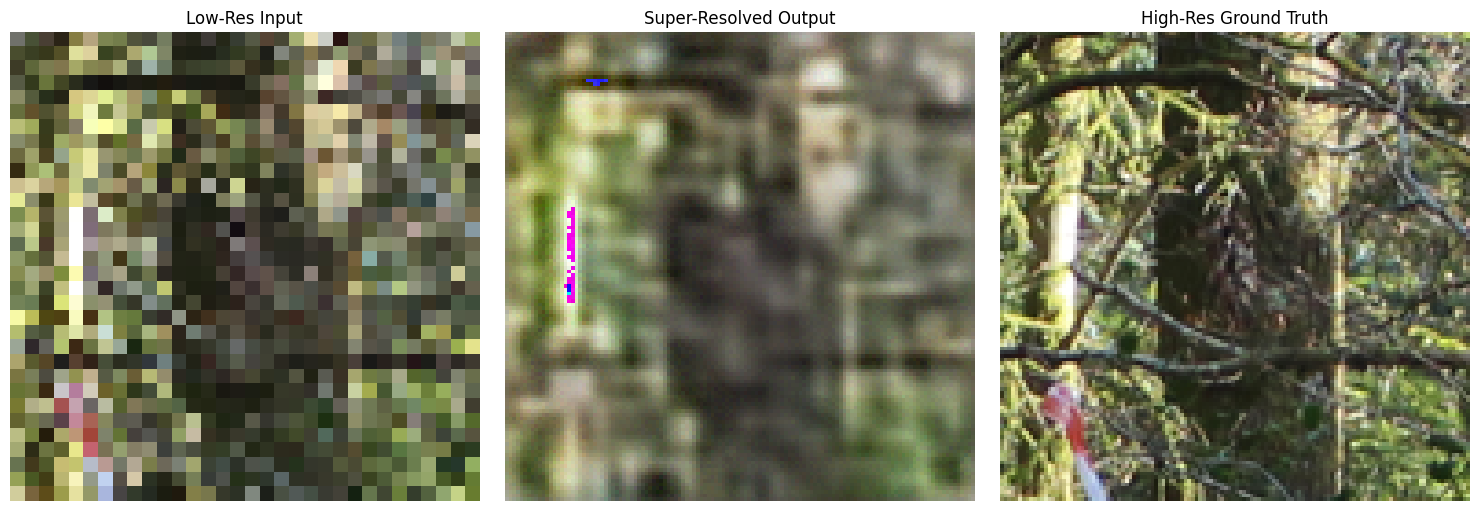

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import matplotlib.pyplot as plt

# --- Dataset Class (Same as before) ---
class Flickr2KDataset(Dataset):
    def __init__(self, hr_size=128, scale=4):
        self.hr_path = "/content/Flickr2K/Flickr2K/Flickr2K_HR"
        self.lr_path = "/content/Flickr2K/Flickr2K/Flickr2K_LR_bicubic/X4"

        self.hr_size = hr_size
        self.scale = scale
        self.image_files = sorted([f for f in os.listdir(self.hr_path) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.hr_path, self.image_files[idx])
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Could not load image: {img_path}")

        h, w = img.shape[:2]
        if h < self.hr_size or w < self.hr_size:
            return self.__getitem__((idx + 1) % len(self))

        top = np.random.randint(0, h - self.hr_size)
        left = np.random.randint(0, w - self.hr_size)
        hr_img = img[top:top+self.hr_size, left:left+self.hr_size]
        lr_img = cv2.resize(hr_img, (self.hr_size // self.scale, self.hr_size // self.scale), interpolation=cv2.INTER_CUBIC)

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)

        hr_img = torch.tensor(hr_img / 127.5 - 1).permute(2, 0, 1).float()
        lr_img = torch.tensor(lr_img / 127.5 - 1).permute(2, 0, 1).float()

        return {'lr': lr_img, 'hr': hr_img}

# --- Simplified SwinIR Model (Same as your definition) ---
# Paste your SwinIR model class here (unchanged)

# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinIR().to(device)
model.load_state_dict(torch.load("/content/swinir_flickr2k.pth"))
model.eval()

# --- Evaluation Function ---
def evaluate_model(model, dataset, num_samples=5):
    psnr_vals, ssim_vals = [], []
    for i in range(num_samples):
        sample = dataset[i]
        lr = sample['lr'].unsqueeze(0).to(device)
        hr = sample['hr'].permute(1, 2, 0).numpy()
        sr = model(lr).squeeze(0).detach().cpu().permute(1, 2, 0).numpy()

        hr = ((hr + 1) * 127.5).astype(np.uint8)
        sr = ((sr + 1) * 127.5).astype(np.uint8)

        psnr = psnr_metric(hr, sr, data_range=255)
        ssim = ssim_metric(hr, sr, data_range=255, win_size=7, channel_axis=-1)

        psnr_vals.append(psnr)
        ssim_vals.append(ssim)

    print(f"\n PSNR: {np.mean(psnr_vals):.2f} dB")
    print(f"SSIM: {np.mean(ssim_vals):.4f}\n")


# --- Visualization Function ---
def show_comparison(model, dataset, idx=0):
    sample = dataset[idx]
    lr = sample['lr'].unsqueeze(0).to(device)
    with torch.no_grad():
        sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()

    hr = sample['hr'].permute(1, 2, 0).numpy()
    lr = sample['lr'].permute(1, 2, 0).numpy()

    sr = (sr + 1) * 127.5
    hr = (hr + 1) * 127.5
    lr = (lr + 1) * 127.5


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(lr.astype(np.uint8))
    plt.title("Low-Res Input")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(sr.astype(np.uint8))
    plt.title("Super-Resolved Output")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(hr.astype(np.uint8))
    plt.title("High-Res Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# --- Run Evaluation ---
val_dataset = Flickr2KDataset()
evaluate_model(model, val_dataset, num_samples=10)
show_comparison(model, val_dataset, idx=0)
